# 正規線形モデル
一般化線形モデルでは、目的変数の確率分布は仮定するが、入力変数の確率分布は仮定しない(そもそもベイズ的には得られた観測値を確率変数として扱わない)。そのため、入力変数として連続値ではない質的データを利用することも可能である。ここでは、ビールの売り上げを目的変数として気温、天気の二つの説明変数から回帰する正規線形モデルを説明する。

## データの説明

In [52]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pymc as pm

In [53]:
beer_sales = pd.read_csv('../data/2-3-beer-sales-weather.csv')

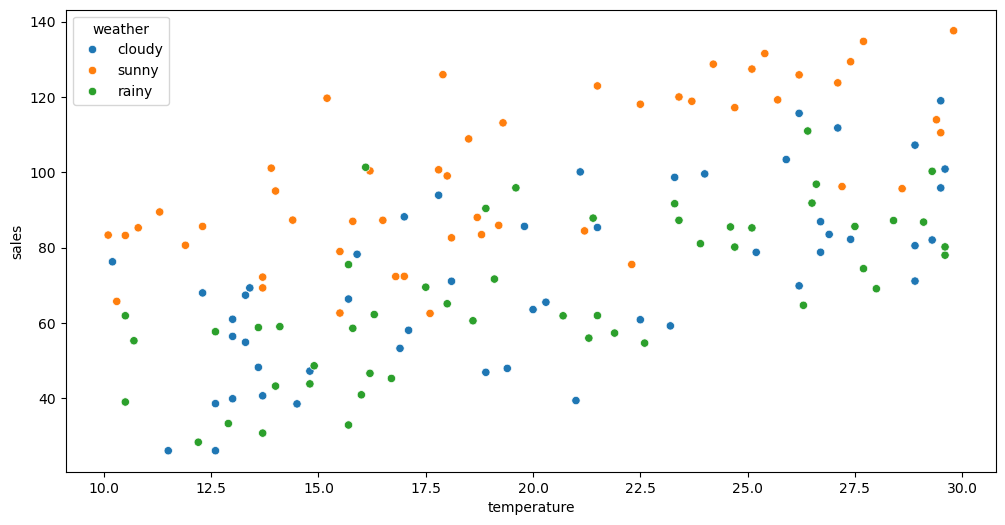

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='temperature', y='sales', data=beer_sales, hue="weather", ax=axes)
plt.show()

一見晴れの日には売り上げが平均して大きくなりそうである。これを見るために売り上げと天気のバイオリンプロットを見てみる。

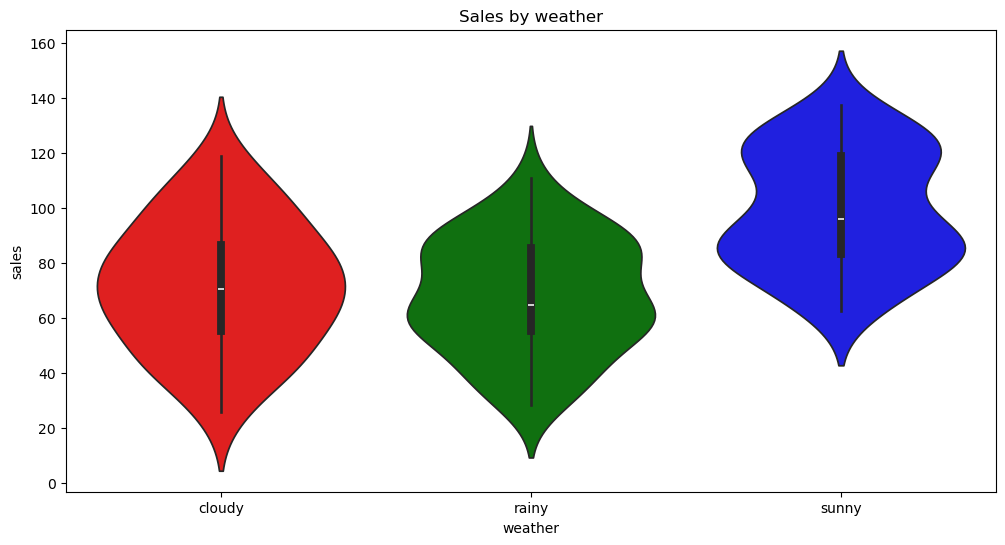

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.violinplot(x='weather', y='sales', data=beer_sales, hue=beer_sales.weather, order=["cloudy", "rainy", "sunny"], palette={"cloudy": "red", "rainy": "green", "sunny": "blue"}, ax=axes)
plt.title('Sales by weather')
plt.show()

確かに晴れの日は売り上げが伸びていそうである。そこで、次のようなモデルを考える。
$$
\mu_i = w_0 + w_1x_{1i} + w_2x_{2i} + w_3x_{3i} \\
y_i \sim Normal(\mu_i, \sigma^2)
$$
ここで、$x_{1i}$は雨の時に1, そうでない時は0になるダミー変数で、$x_{2i}$も同様に晴れの時に1, そうでない時は0になるダミー変数である。$x_{3i}$は気温であり、連続変数である。つまり、天気によって$\mu_i$の値は次のようになる。
$$
晴れの時 \quad \mu_i = w_0 +w_2 + w_3x_{3i} \\
雨の時 \quad \mu_i = w_0 + w_1 + w_3x_{3i} \\
曇りの時 \quad \mu_i = w_0 + w_3x_{3i}
$$
よって、天気によって切片の大きさが変わり、傾きは変化しないモデルになる。

## pymcでの実装

このモデルはpyMCで次のように書ける。

In [56]:
y = beer_sales.sales
temp = beer_sales.temperature
weather = pd.get_dummies(beer_sales.weather).astype(int)
rainy = weather['rainy']
sunny = weather['sunny']

In [94]:
linear_model = pm.Model()
with linear_model:
    linear_model.add_coord("data", values=range(len(beer_sales)), mutable=True)
    # X, Yの観測値をMutableDataとして定義
    temp_data = pm.MutableData('temp_data', temp, dims="data")
    rainy_data = pm.MutableData('rainy_data', rainy, dims="data")
    sunny_data = pm.MutableData('sunny_data', sunny, dims="data")
    Y_data = pm.MutableData('Y_data', y, dims="data")

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    w2 = pm.Normal("w2", mu=0, sigma=20)
    w3 = pm.Normal("w3", mu=0, sigma=20)

    # 平均値muの計算
    mu = pm.Deterministic("mu", w0 + w1 * rainy_data + w2 * sunny_data + w3 * temp_data, dims="data")

    #　誤差を示す確率変数sigmaの定義
    sigma = pm.HalfCauchy("sigma", beta=10)

    # 観測値が従う確立分布の定義
    y_pred = pm.Normal('y', mu=mu, sigma=sigma, observed=Y_data, dims="data")

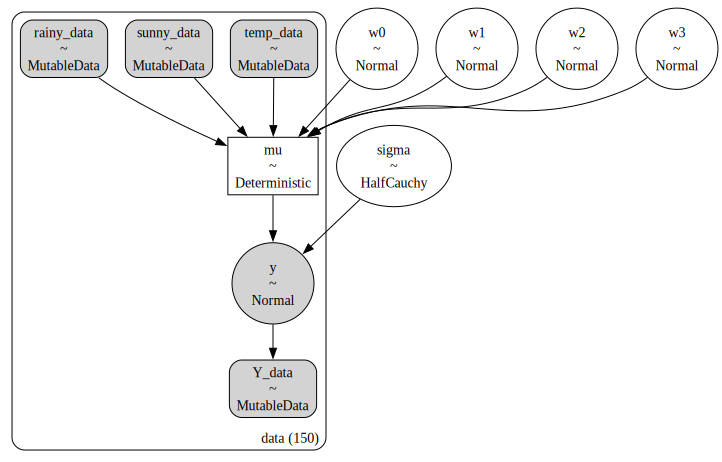

In [95]:
g = pm.model_to_graphviz(linear_model)
display(g)

In [59]:
with linear_model:
    trace = pm.sample(
        # 乱数系列の数(デフォルト2)
        chains=3,
        # 捨てるサンプル数(デフォルト1000)
        tune=2000,
        # 取得するサンプル数(デフォルト1000)
        draws=3000,
        cores = 4,
        random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w0, w1, w2, w3, sigma]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,19.460,4.893,10.108,28.389,0.070,0.050,4913.0,4690.0,1.0
w1,-3.579,3.136,-9.692,2.076,0.040,0.031,6317.0,5459.0,1.0
w2,29.028,3.109,23.054,34.800,0.040,0.028,6015.0,5919.0,1.0
w3,2.589,0.217,2.178,2.994,0.003,0.002,5663.0,5349.0,1.0
sigma,15.984,0.944,14.283,17.769,0.011,0.008,7411.0,5773.0,1.0


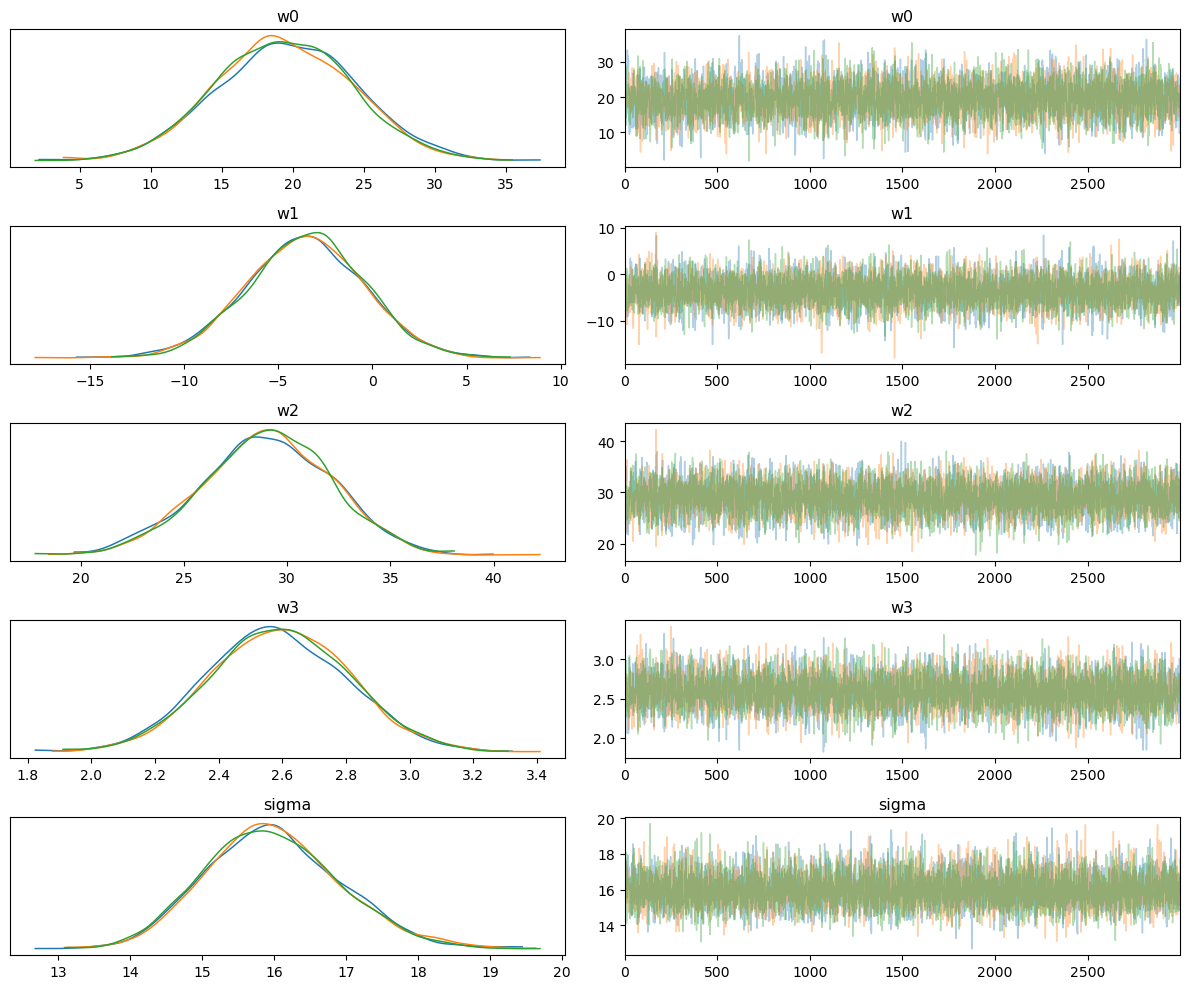

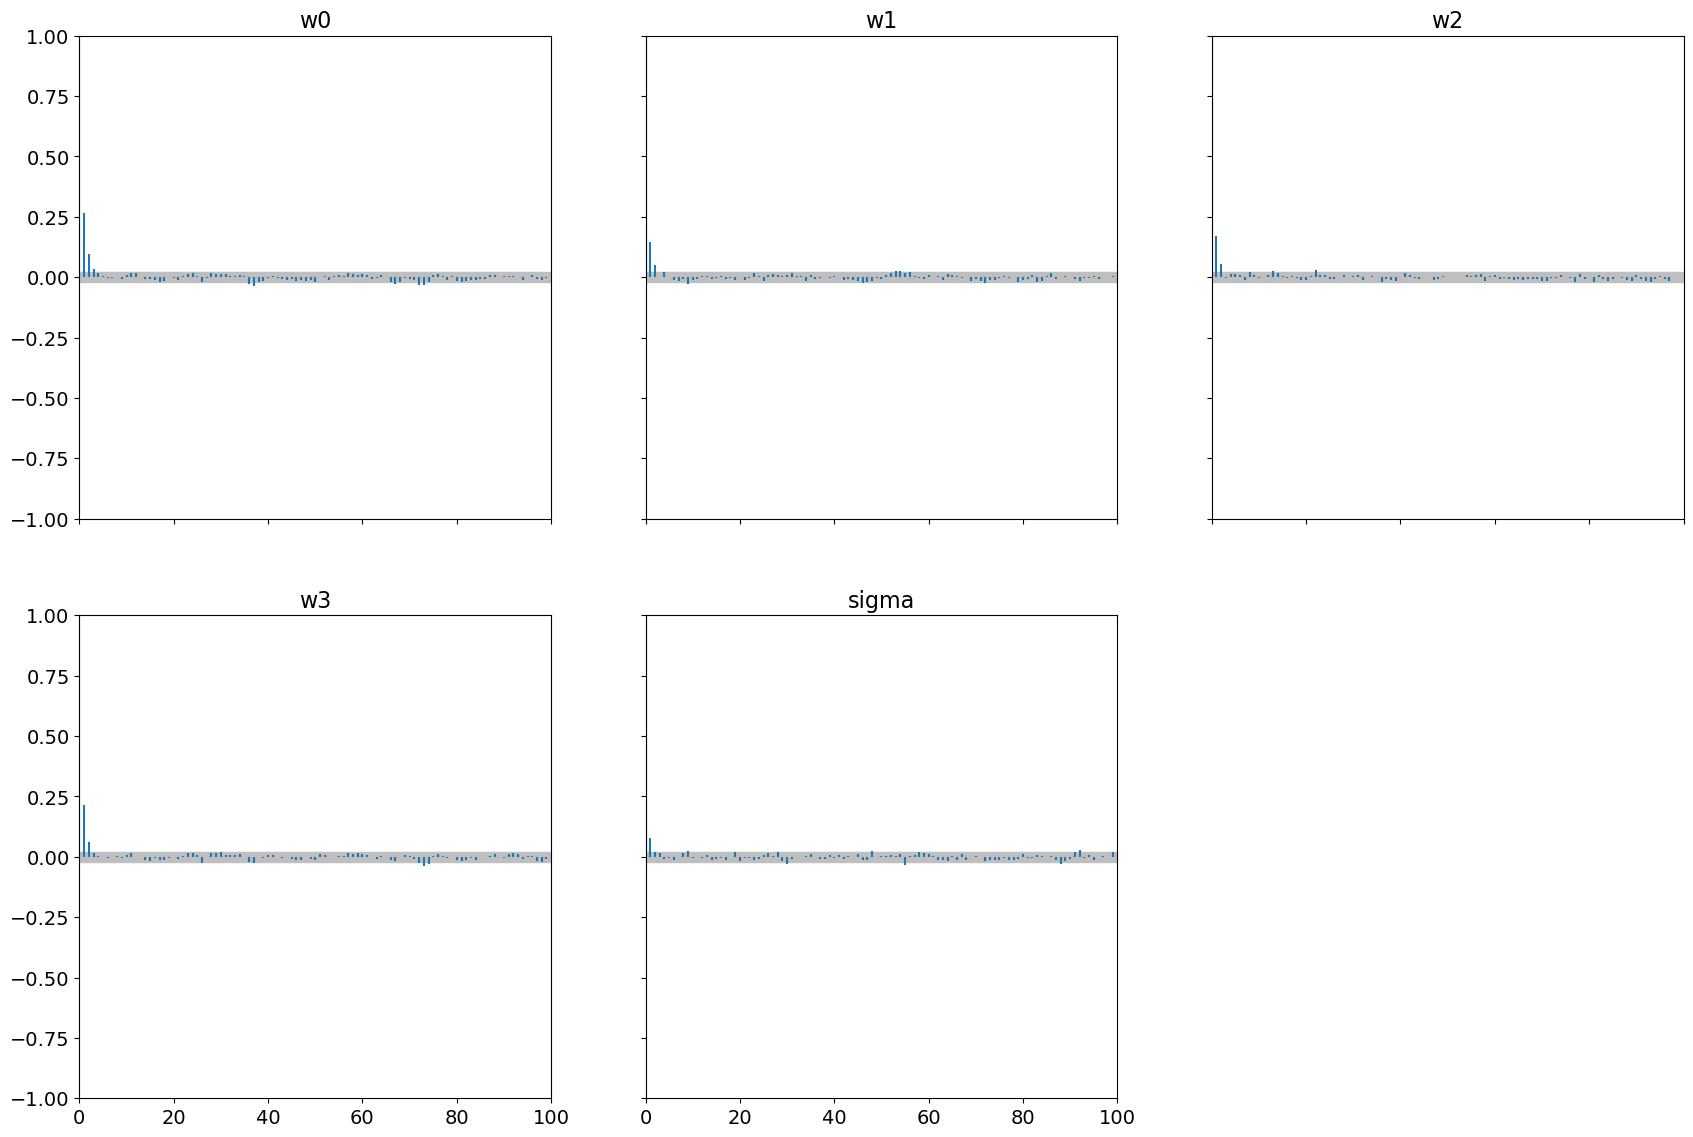

In [60]:
summary = az.summary(trace, var_names=["w0", "w1", "w2", "w3", "sigma"])
display(summary)

az.plot_trace(trace, var_names=["w0", "w1", "w2", "w3", "sigma"], compact=False)
plt.tight_layout()

az.plot_autocorr(trace, var_names=["w0", "w1", "w2", "w3", "sigma"], combined=True)
plt.show()

これらの結果からうまく収束していることがわかる。

では、パラメータの事後分布を確認する。

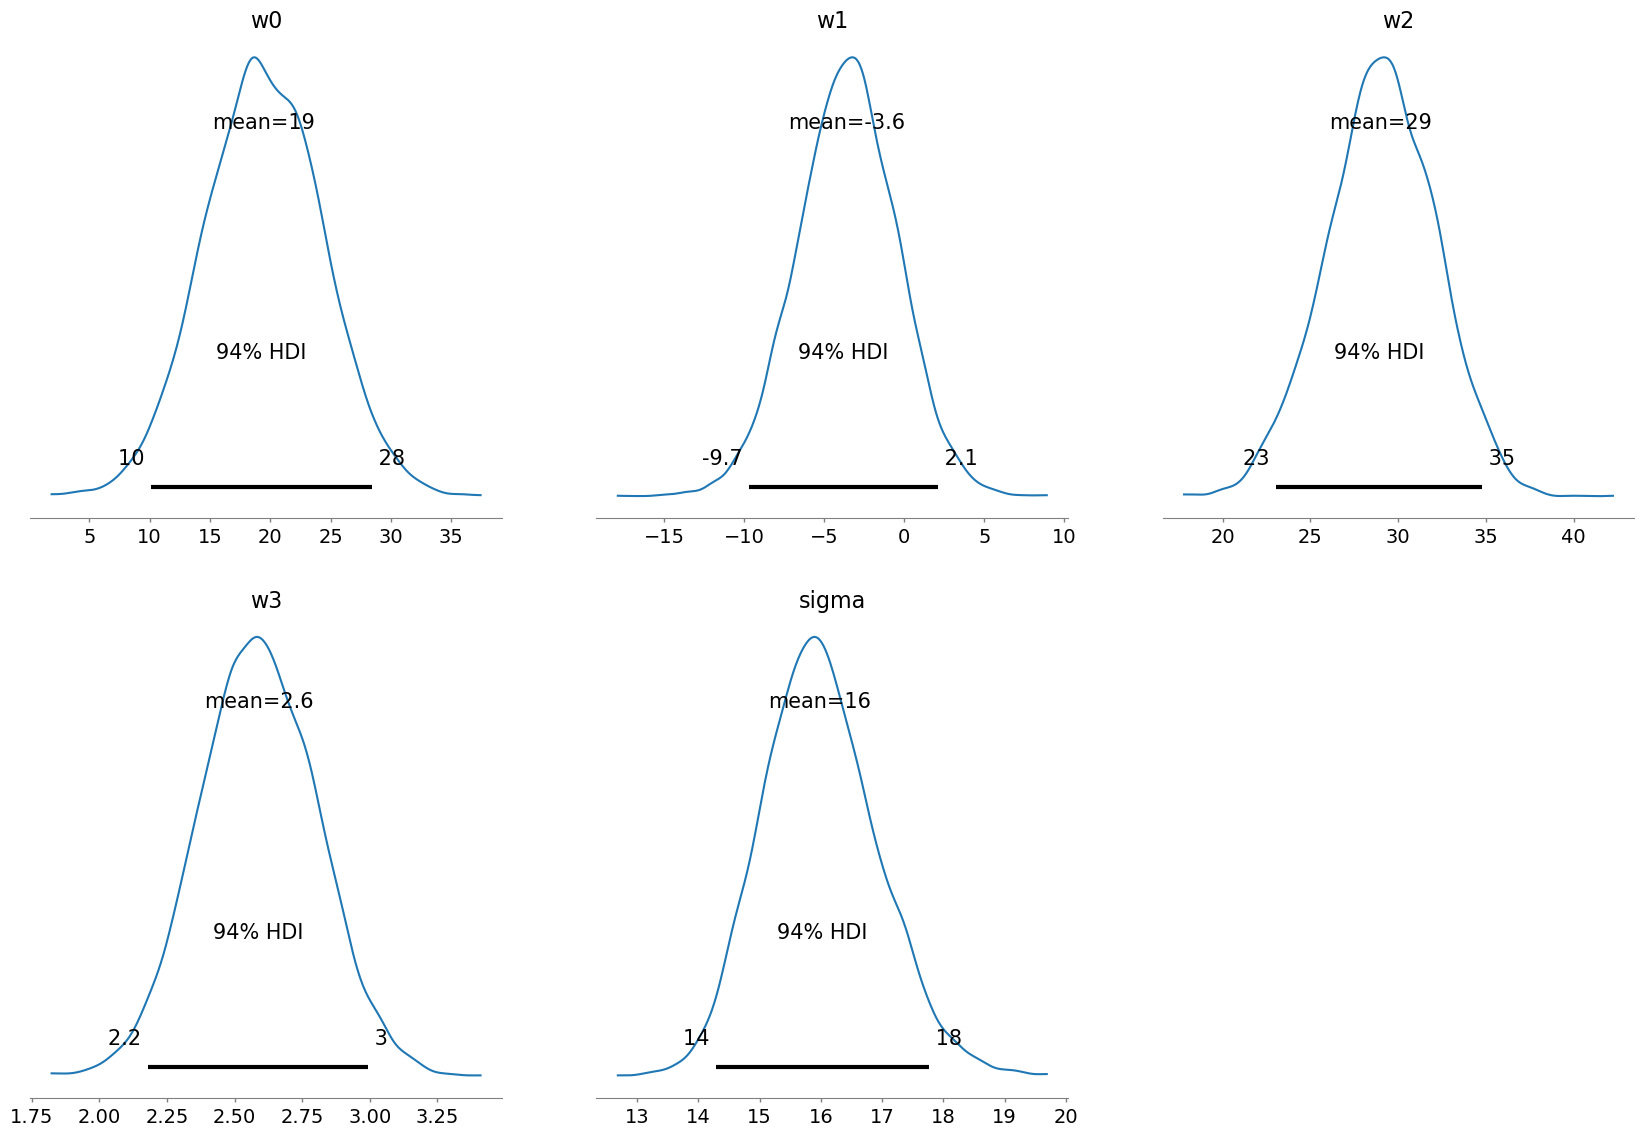

In [61]:
plt.rcParams['figure.figsize'] = (6, 6)
ax = az.plot_posterior(trace, var_names=["w0", "w1", "w2", "w3", "sigma"])

これをみると、曇りの日の切片$w_0$の期待値は19であり、晴れの日には$w_2$の期待値29が切片として加わることがわかる。このことから晴れの日には確かにビールの売り上げが約30万円伸びることがわかる。また、雨の日には切片に$w_1$の期待値-2.9が加わり、雨の日には売り上げが3万円ほど落ちるように思えるが、$w_1$のHDIは0を含んでおり、$w_1=0$になる確率は低くないことがわかる。そのため雨の日と曇りの日はほとんど売り上げは変わらないと見て良い。

### 信用区間付き回帰直線
信用区間付き回帰直線を見ることで、上の議論を視覚的に確認する。

In [88]:
temp_test = np.tile(np.linspace(temp.min(), temp.max(), 100), 3)
sunny_test = np.array([1] * 100 + [0] * 100 + [0] * 100)
rainy_test = np.array([0] * 100 + [1] * 100 + [0] * 100)
sunny_idx = 100
rainy_idx = 200

In [89]:
pred_model = pm.Model()
with pred_model:
    pred_model.add_coord("data", values=range(len(temp_test)), mutable=True)
    # X, Yの観測値をMutableDataとして定義
    temp_data = pm.MutableData('temp_test', temp_test, dims="data")
    rainy_data = pm.MutableData('rainy_test', rainy_test, dims="data")
    sunny_data = pm.MutableData('sunny_test', sunny_test, dims="data")

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    w2 = pm.Normal("w2", mu=0, sigma=20)
    w3 = pm.Normal("w3", mu=0, sigma=20)

    # 平均値muの計算
    mu = pm.Deterministic("mu", w0 + w1 * rainy_data + w2 * sunny_data + w3 * temp_data)

    #　誤差を示す確率変数sigmaの定義
    sigma = pm.HalfCauchy("sigma", beta=10)

    # 観測値が従う確立分布の定義
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, dims="data")
    
    prediction = pm.sample_posterior_predictive(trace, var_names=["y_pred", "mu"], predictions=True).predictions

Sampling: [y_pred]


In [90]:
sunnies = beer_sales[beer_sales.weather == "sunny"]
rainies = beer_sales[beer_sales.weather == "rainy"]
cloudies = beer_sales[beer_sales.weather == "cloudy"]

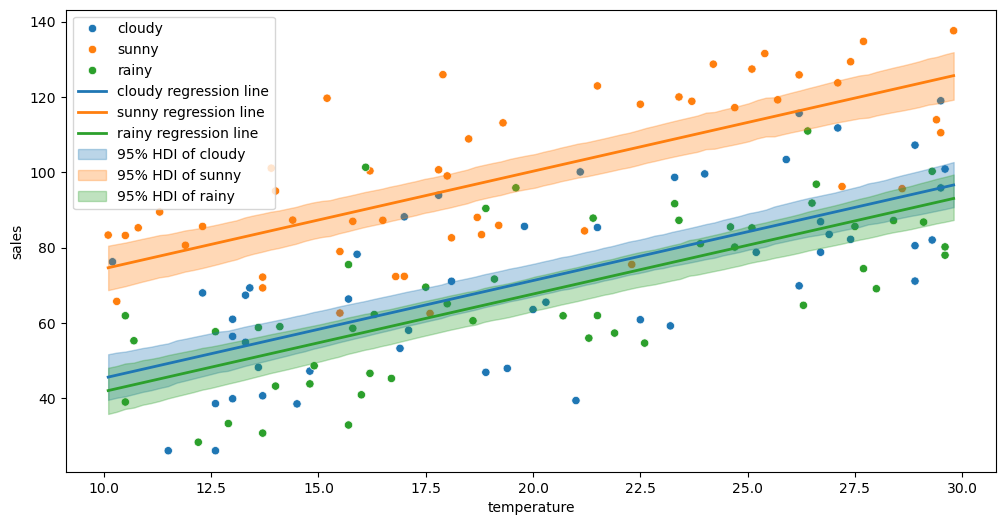

In [91]:
temp_values = np.array([temp.min(), temp.max()])
cmap = plt.get_cmap("tab10")

# 平均回帰直線の計算
w0_mean = summary['mean'].w0
w1_mean = summary['mean'].w1
w2_mean = summary['mean'].w2
w3_mean = summary['mean'].w3
sunny_mean = w0_mean + w2_mean + w3_mean * temp_values
rainy_mean = w0_mean + w1_mean + w3_mean * temp_values
cloudy_mean = w0_mean + w3_mean * temp_values

# 各天気の気温データ
sunny_temp = temp_test[:sunny_idx]
rainy_temp = temp_test[sunny_idx:rainy_idx]
cloudy_temp = temp_test[rainy_idx:]

# 各天気の95% HDIの計算
hdis = az.hdi(prediction, hdi_prob=0.95)["mu"].values
hdi_sunny = hdis[:100]
hdi_rainy = hdis[100:200]
hdi_cloudy = hdis[200:]


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='temperature', y='sales', data=beer_sales, hue="weather", ax=axes)    # 観測値の散布図

#各天気の回帰直線
axes.plot(temp_values, cloudy_mean, lw=2, c=cmap(0), label='cloudy regression line')
axes.plot(temp_values, sunny_mean, lw=2, c=cmap(1), label='sunny regression line')
axes.plot(temp_values, rainy_mean, lw=2, c=cmap(2), label='rainy regression line')


# 各天気の95% HDI
axes.fill_between(cloudy_temp, y1=hdi_cloudy[:,0], y2=hdi_cloudy[:,1], color=cmap(0), alpha=0.30, label="95% HDI of cloudy")
axes.fill_between(sunny_temp, y1=hdi_sunny[:,0], y2=hdi_sunny[:,1], color=cmap(1), alpha=0.30, label="95% HDI of sunny")
axes.fill_between(rainy_temp, y1=hdi_rainy[:,0], y2=hdi_rainy[:,1], color=cmap(2), alpha=0.30, label="95% HDI of rainy")

plt.legend()
plt.show()

これを見てわかる通り、晴れの日は確かに切片が大きくなり、売り上げが上がる。しかし、雨の日と曇りの日はお互いの信用区間の中に平均回帰直線が入っており、ほとんど切片に変化がないと言える。

## pystanでの実装

In [38]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import stan
import nest_asyncio
nest_asyncio.apply()

In [3]:
beer_sales = pd.read_csv('../data/2-3-beer-sales-weather.csv')

デザイン行列を作成してstanに読み込ませる。

In [33]:
y = beer_sales.sales.values
temp = beer_sales.temperature.values.reshape(-1, 1)
weather = pd.get_dummies(beer_sales.weather, drop_first=True, dtype=int).values
intercept = np.ones_like(y).reshape(-1, 1)
X = np.concatenate([intercept, weather, temp], axis=1)
N = len(y)
K = X.shape[1]

In [85]:
temp_pred = np.tile(np.linspace(temp.min(), temp.max(), 100), 3).reshape(-1, 1)
weather_pred = np.array([0, 0] * 100 + [0, 1] * 100 + [1, 0] * 100).reshape(-1, 2)
intercept_pred = np.ones(300).reshape(-1, 1)
X_pred = np.concatenate([intercept_pred, weather_pred, temp_pred], axis=1)
N_pred = len(X_pred)

In [86]:
stan_data = {
    "N": N,
    "K": K,
    "y": y,
    "X": X,
    "N_pred": N_pred,
    "X_pred": X_pred
    }

In [87]:
with open("../stan/2-3-linear-model.stan") as f:
    stan_code = f.read()

In [88]:
sm = stan.build(stan_code, data=stan_data, random_seed=123)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [89]:
fit = sm.sample(num_chains=3, num_samples=6000, num_warmup=1000, num_thin=2)

Sampling:   0%
Sampling:  33% (7000/21000)
Sampling:  67% (14000/21000)
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 9.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.95 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
  Adjust your expectations accordingly!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],20.207,5.032,10.647,29.661,0.060,0.043,6966.0,7571.0,1.0
beta[1],-3.538,3.152,-9.591,2.196,0.037,0.027,7151.0,8165.0,1.0
beta[2],29.433,3.195,23.581,35.533,0.037,0.026,7497.0,7762.0,1.0
beta[3],2.548,0.225,2.134,2.973,0.003,0.002,7346.0,7484.0,1.0
sigma,16.057,0.952,14.284,17.833,0.010,0.007,8655.0,7199.0,1.0


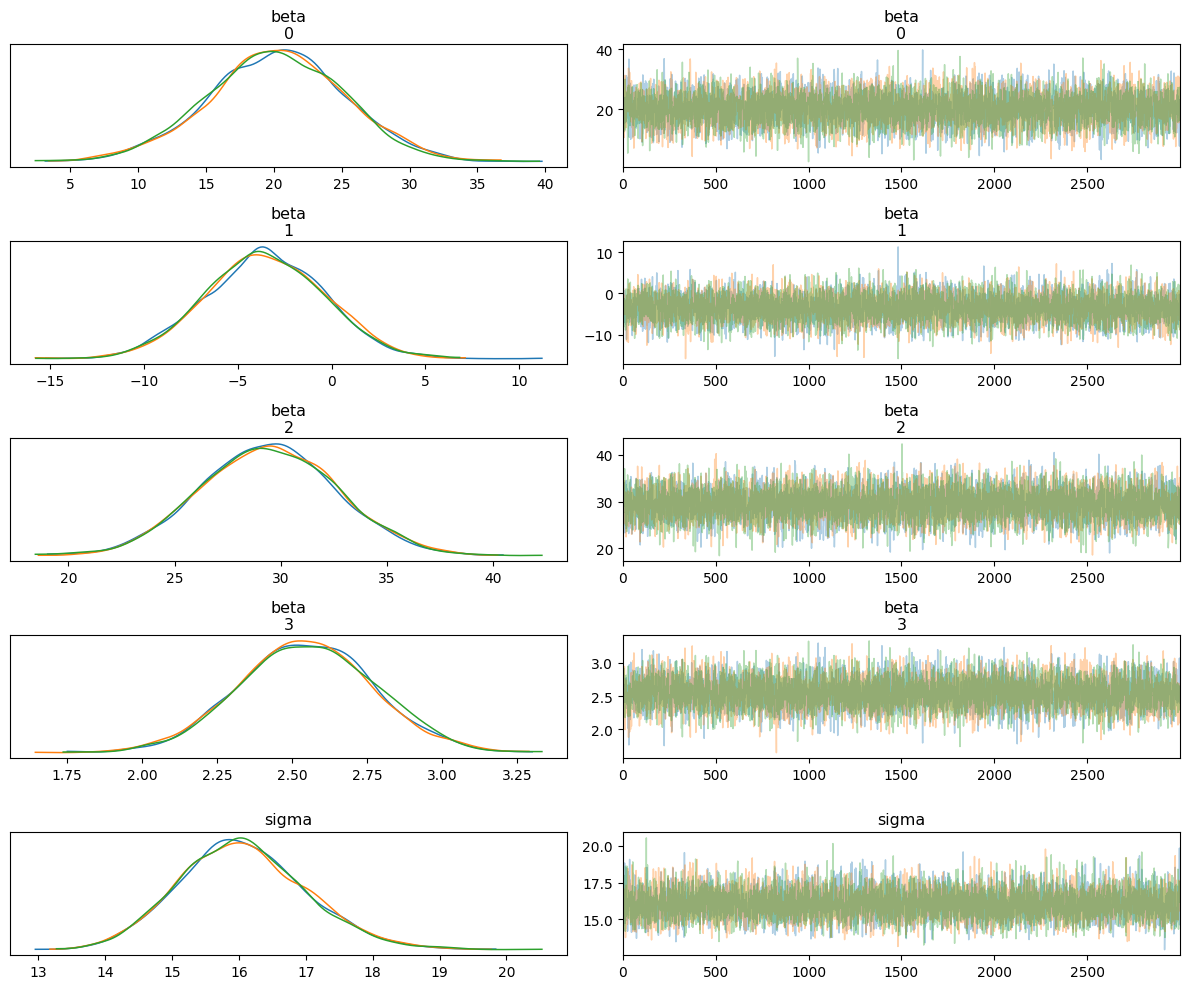

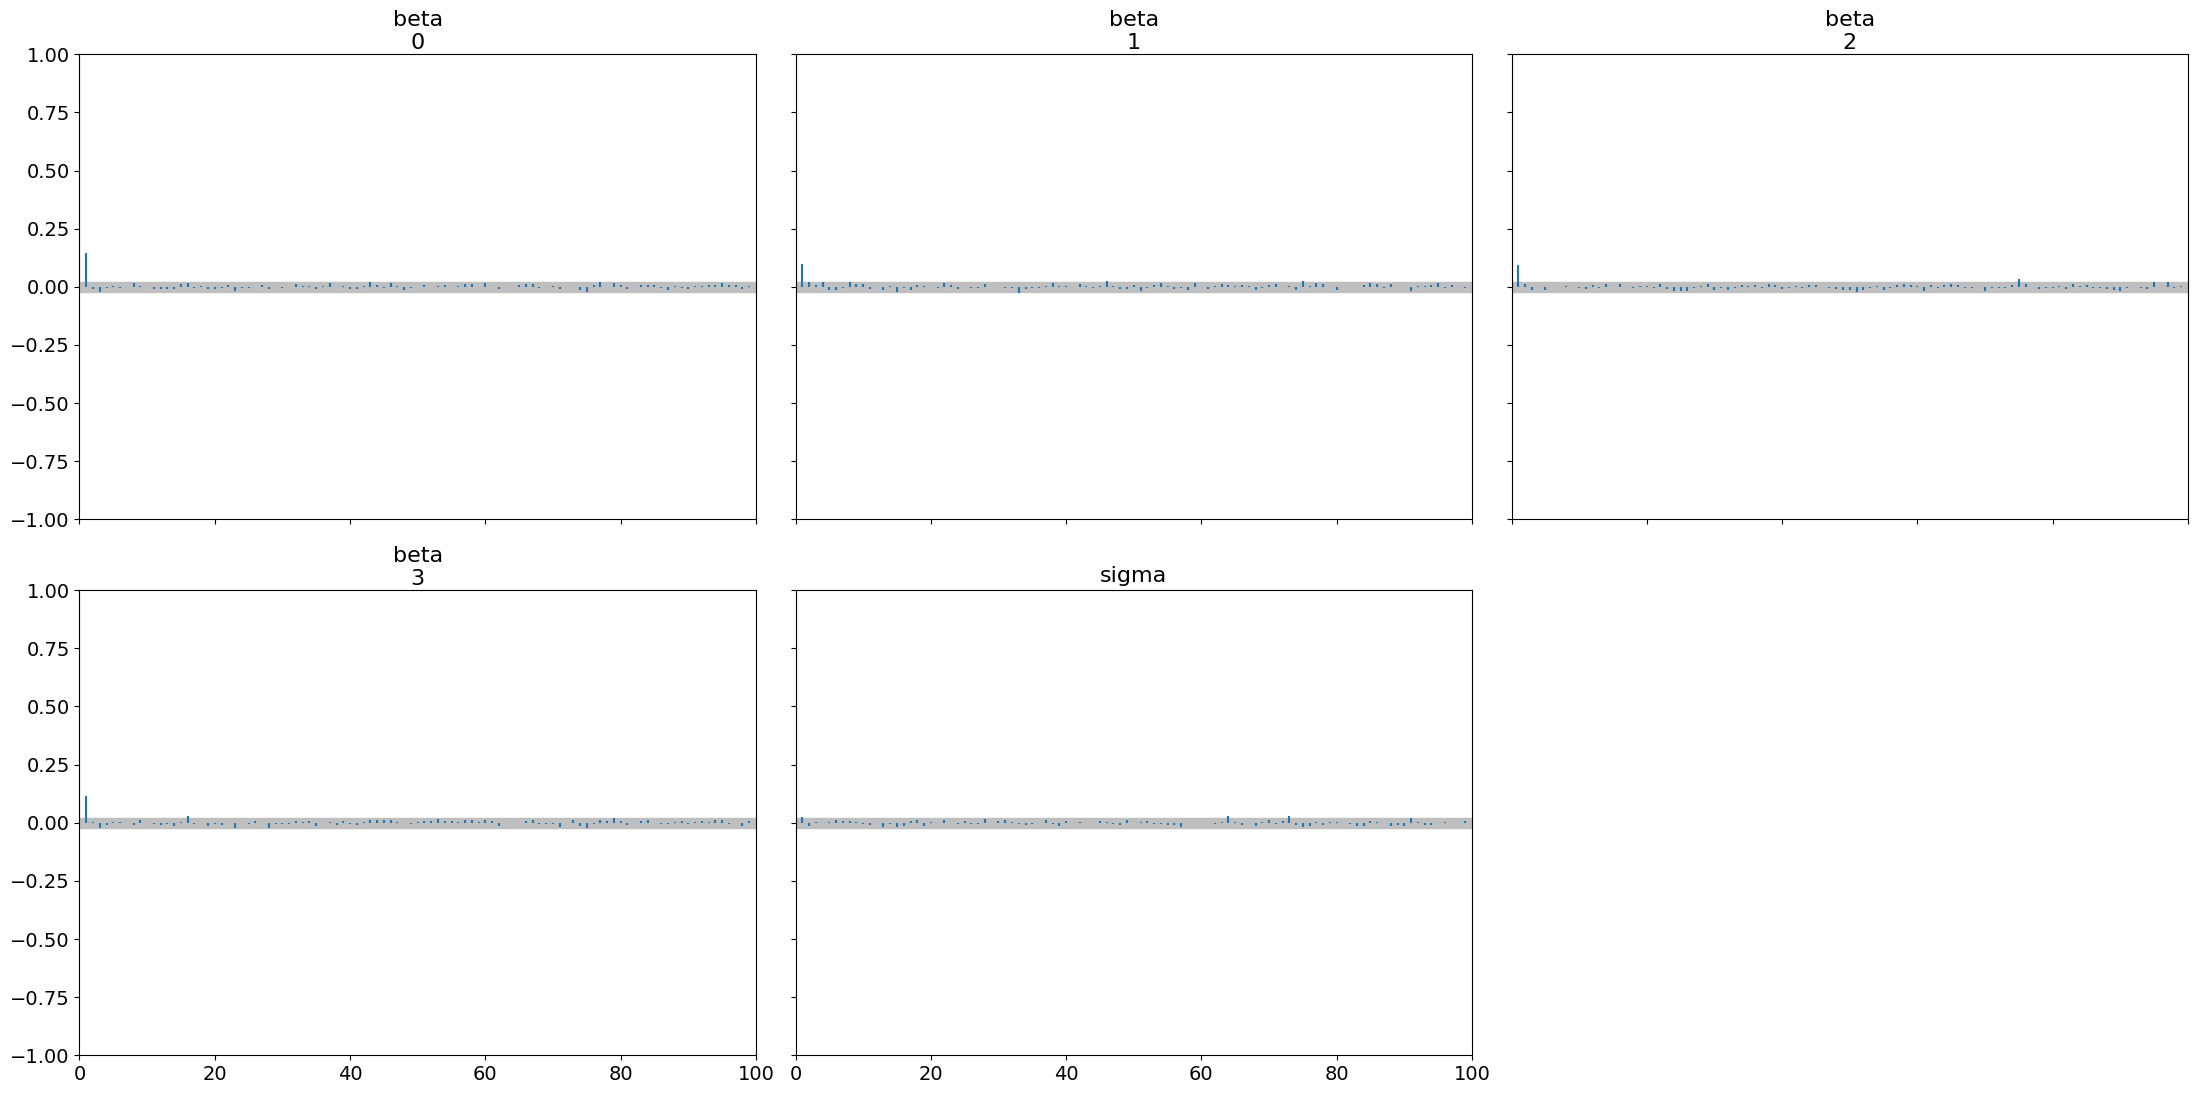

In [90]:
summary = az.summary(fit, var_names=["beta", "sigma"])
display(summary)
az.plot_trace(fit, var_names=["beta", "sigma"], compact=False)
plt.tight_layout()

az.plot_autocorr(fit, var_names=["beta", "sigma"], combined=True)
plt.tight_layout()

In [91]:
temp_pred = X_pred[:100, -1]
cloudy_idx = ~np.any(X_pred[:, 1:3], axis=1)
sunny_idx = X_pred[:, 2]==1
rainy_idx = X_pred[:, 1]==1

cloudy_X = X_pred[cloudy_idx]
sunny_X = X_pred[sunny_idx]
rainy_X = X_pred[rainy_idx]

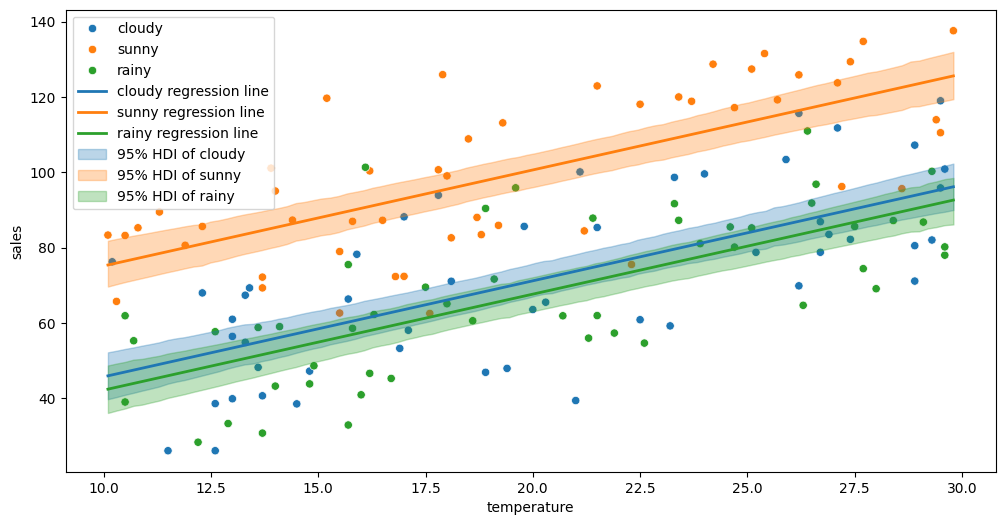

In [92]:
cmap = plt.get_cmap("tab10")

# 平均回帰直線の計算
beta = summary["mean"][summary.index.str.contains("beta")].values
sunny_mean = np.dot(sunny_X, beta)
rainy_mean = np.dot(rainy_X, beta)
cloudy_mean = np.dot(cloudy_X, beta)

# 各天気の95% HDIの計算
hdis = az.hdi(fit, hdi_prob=0.95)["mu_pred"].values
hdi_sunny = hdis[sunny_idx]
hdi_rainy = hdis[rainy_idx]
hdi_cloudy = hdis[cloudy_idx]


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='temperature', y='sales', data=beer_sales, hue="weather", ax=axes)    # 観測値の散布図

#各天気の回帰直線
axes.plot(temp_pred, cloudy_mean, lw=2, c=cmap(0), label='cloudy regression line')
axes.plot(temp_pred, sunny_mean, lw=2, c=cmap(1), label='sunny regression line')
axes.plot(temp_pred, rainy_mean, lw=2, c=cmap(2), label='rainy regression line')


# 各天気の95% HDI
axes.fill_between(temp_pred, y1=hdi_cloudy[:,0], y2=hdi_cloudy[:,1], color=cmap(0), alpha=0.30, label="95% HDI of cloudy")
axes.fill_between(temp_pred, y1=hdi_sunny[:,0], y2=hdi_sunny[:,1], color=cmap(1), alpha=0.30, label="95% HDI of sunny")
axes.fill_between(temp_pred, y1=hdi_rainy[:,0], y2=hdi_rainy[:,1], color=cmap(2), alpha=0.30, label="95% HDI of rainy")

plt.legend()
plt.show()